In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import Normalizer, StandardScaler

from kmodes.kprototypes import KPrototypes
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [82]:
df = pd.read_csv(r'C:\Users\TSmeitink\Google Drive\DDMA Hackathon\complete_hackathon_dataset.csv').sample(10_000)

In [83]:
df.dtypes

gwb_code_10                        int64
gwb_code_8                         int64
regio                             object
gm_naam                           object
gwb_code                          object
aantal_inwoners                    int64
mannen                           float64
vrouwen                          float64
0_tot_15                         float64
15_tot_25                        float64
25_tot_45                        float64
45_tot_65                        float64
65_+                             float64
ongehuwd                         float64
gehuwd                           float64
gescheiden                       float64
migratieachtergrond              float64
geboorte_relatief                  int64
sterfte_relatief                   int64
huishoudens                        int64
eenpersoonshuishoudens           float64
huishoudens_zonder_kinderen      float64
huishoudens_met_kinderen         float64
gemiddelde_huishoudensgrootte    float64
bevolkingsdichth

In [84]:
df['score_voorzieningen_2018']

85776     0.032577
67102     0.101094
27071    -0.086193
138827    0.008344
88832     0.221403
90190     0.203834
84671    -0.017139
42704    -0.033197
103644    0.075114
44939    -0.024059
107686    0.070730
145071    0.007068
141777   -0.031562
128067   -0.123360
9102      0.101647
147218   -0.068742
22613    -0.001480
63423     0.216978
128710   -0.092251
24233     0.049535
137676   -0.011799
86394     0.377145
96861    -0.016543
42511     0.023335
50854     0.071549
28735    -0.107994
91924     0.223629
113166   -0.039023
18093     0.078741
144669   -0.138285
            ...   
112014   -0.160823
76951     0.022958
168051   -0.342885
15148     0.040092
133189   -0.006008
120736   -0.116069
84297     0.161595
76633     0.023026
66995     0.146385
110007    0.061804
37810    -0.155866
78691     0.050793
73869    -0.036462
165032   -0.061456
89649     0.264063
56924     0.149176
100655    0.192648
39338    -0.092954
101716    0.266331
94720     0.355059
140164    0.051761
107569    0.

In [85]:
scaler = StandardScaler()

fields = ['indexed_price', 'build_year', 'use_surface', 'parcel_surface', 'number_of_objects', 'score_totaal_2018',
         'huishoudens_met_kinderen', '65_+', 'aantal_inwoners']
X = scaler.fit_transform(df[fields].dropna())

new_df = pd.DataFrame(X, columns=fields)

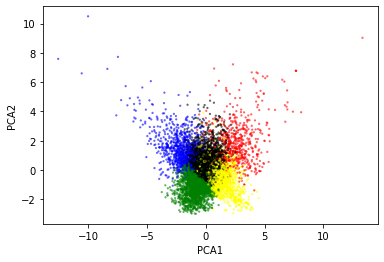

In [86]:
new_df['clusters'] = KMeans(n_clusters=5).fit(X).labels_

pca = PCA(n_components=2)
pca_comp = np.transpose(pca.fit_transform(new_df[fields]))

colors = {0: 'red', 1:'blue', 2: 'green', 3: 'yellow', 4: 'black'}
plt.scatter(pca_comp[0], pca_comp[1], c=new_df['clusters'].map(colors), edgecolor='none', alpha=0.6, s=5)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.show();

In [87]:
new_df['clusters'].value_counts()

4    3833
2    2610
3    1953
1     987
0     617
Name: clusters, dtype: int64

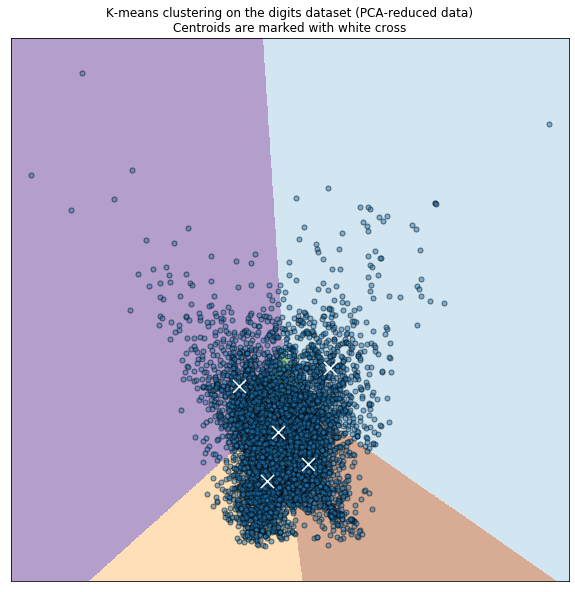

In [88]:
reduced_data = PCA(n_components=2).fit_transform(new_df[fields])
kmeans = KMeans(init='k-means++', n_clusters=5, n_init=10)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(10, 10))
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower', alpha=0.5)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=5, marker='o', mec='black', c=None, alpha=0.5)

# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)
plt.title('K-means clustering on the digits dataset (PCA-reduced data)\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()